<a href="https://colab.research.google.com/github/sim-so/HandsOnML/blob/main/03_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 분류 Classification
1. scikit-learn 라이브러리 사용법 익히기
2. 이진 분류 / 다중 분류 수행하기
3. 모델의 성과 분석하기
- 실습에 사용한 모델들이 어떤 원리로 분류를 수행하는지는 5~7장에 걸쳐 공부할 예정이므로,\
이번 장에서는 전반적인 머신러닝 수행과정에 초점을 두고 실습을 진행해봅시다.

## Load Library

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

## Functions
데이터 시각화를 위한 함수를 사전 정의합니다.

In [3]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=mpl.cm.binary, interpolation="nearest")
    plt.axis("off")

In [4]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    image_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size, size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

## 1. MNIST
MNIST 데이터셋은 가장 기본적인 이미지 데이터셋입니다.\
0에서 9까지 숫자들의 손글씨 이미지로 크기는 784 = (28, 28), 색상은 흑백입니다.\
7만개의 데이터 중 마지막 1만개는 테스트 데이터로서 사용합니다.

### 데이터셋 다운로드

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)        # default: as_frame=True
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

### 이미지 데이터 확인

In [6]:
X, y = mnist['data'], mnist['target']
print(X.shape, y.shape)

(70000, 784) (70000,)


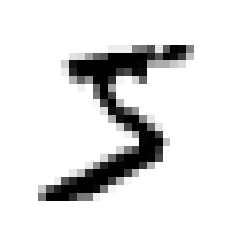

In [7]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis("off")
plt.show()

In [8]:
y[0]

'5'

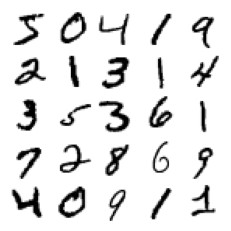

In [9]:
plot_digits(X[:25], images_per_row=5)

### 데이터셋 분할
책에서는 slicing으로 훈련 세트와 테스트 세트를 나누었습니다.\
sklearn.model_seletion.train_test_split()을 사용하여도 같은 결과를 만들 수 있습니다.

In [10]:
y = y.astype(np.uint8)

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [12]:
# compare
from sklearn.model_selection import train_test_split

X_tr, X_tt, y_tr, y_tt = train_test_split(X, y, test_size=10000, shuffle=False)

In [13]:
print(np.sum(X_tt != X_test, axis=None))
print(np.sum(y_tt != y_test, axis=None))

0
0


## 2. 이진 분류기 훈련
이진 분류를 수행하기 위해 0~9로 구성된 label로부터 0(!=5), 1(==5)로 구성된 label을 새로 생성합니다.\
이번에 사용하는 모델은 SGD(Stochastic Gradient Descent)로, 4장에서 상세히 소개됩니다.

In [14]:
y_train_5 = (y_train == 5) # True if 5 else False
y_test_5 = (y_test == 5)

In [15]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [16]:
sgd_clf.predict([some_digit])       # some_digit == 5

array([ True])

## 3. 성능 측정
- 교차 검증(cross validation)을 통해 모델의 성능을 검증합니다.
- 여러 평가 지표들을 통해 모델을 평가합니다: 오차 행렬(confusion matrix), accuracy, recall, precision, f1-score, roc-auc score

### 교차 검증을 사용한 정확도 측정
교차 검증은 일정 횟수만큼 훈련 세트와 검증 세트를 바꾸어가며 검증을 진행하는 방법입니다.\
모델의 성능은 초기 가중치 등 무작위한 요소의 영향도 받지만, 훈련 데이터에 따라서도 달라질 수 있습니다.

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [18]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

정확도가 90% 이상이라는 의미가 반드시 성능이높다는 의미는 아닙니다.\
사용하고 있는 데이터셋에서 10개 중 9개는 레이블이 0('5'가 아님)이기 때문에, 10개를 모두 0으로 해도 90%의 정확도를 얻을 수 있습니다.

In [19]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)    

In [20]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

### 오차 행렬
scikit-learn의 confusion matrix는 이진분류 시 다음 형태로 오차행렬을 출력합니다.

||Predicted Negative|Predicted Positive|
|---|---|---|
|Actual Negative|True Negative|False Positive|
|Actual Positive|False Negative|True Positive|

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [ ]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### 정밀도와 재현율
- 정밀도 precision = TP / (TP + FP) \
- 재현율 recall = TP / (TP + FN)

In [ ]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


In [ ]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### 정밀도/재현율 트레이드오프
정밀도와 재현율을 둘 다 개선하는 것은 어렵습니다.\
따라서, 적절한 수준의 정밀도와 재현율을 얻을 수 있는 임계값(threshold)를 정하는 것이 중요합니다.\
scikit-learn에서는 decision_function을 통해 각 샘플이 양성 클래스에 속할 확률값을 얻을 수 있습니다.

In [ ]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[2164.22030239]
[ True]


In [ ]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

precision recall curve를 통해 임계값에 따른 precision, recall의 변화를 확인할 수 있습니다.

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

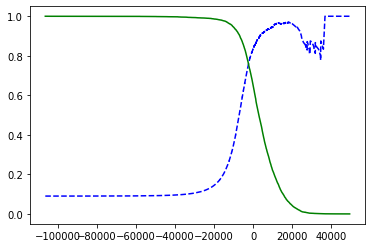

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="recall")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

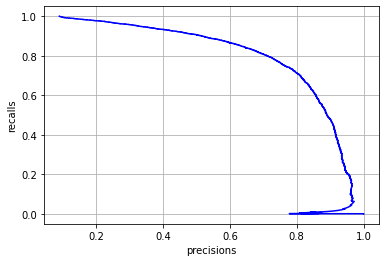

In [ ]:
plt.plot(precisions, recalls, "b-")
plt.xlabel("precisions")
plt.ylabel("recalls")
plt.grid(True)
plt.show()

In [ ]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


### ROC 곡선
ROC 곡선은 FPR에 대한 TPR의 비율입니다.\
FPR은 낮을수록 좋으므로 결과적으로 ROC 곡선 아래의 면적이 넓을수록(=AUC score가 1에 가까울수록) 좋은 모델입니다.
- FPR = FP / (FP + FN)
- TPR = TP / (TP + FN)

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

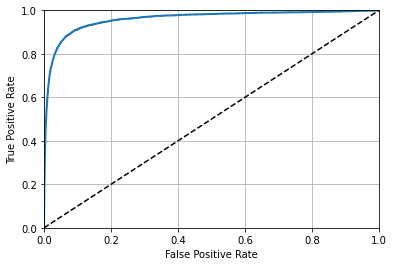

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid(True)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
plot_roc_curve(fpr, tpr)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [ ]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

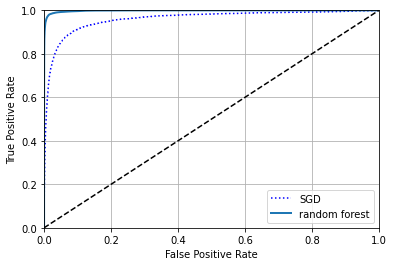

In [ ]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "random forest")
plt.legend(loc="lower right")
plt.show()

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## 4. 다중 분류
셋 이상의 클래스를 구분하기 위해서는 다중 분류기가 필요합니다.\
다중 분류기 중 여러 개의 이진 분류기를 사용하는 경우, 분류 방식에 따라 OvR, OvO로 구분합니다.
- OvR : One-versus-the-rest. 레이블을 (타겟, 그 외 나머지)로 두고 각 분류기를 훈련시킵니다. N개의 분류기가 필요합니다.
- OvO : One-versus-all. 0과 1, 0과 2, ... , 8과 9와 같이 클래스들을 둘씩 조합하여 여러 개의 분류기를 훈련시킵니다. N(N-1)/2개의 분류기가 필요합니다.

In [ ]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [ ]:
print(np.argmax(some_digit_scores))
print(svm_clf.classes_)
print(svm_clf.classes_[5])

5
[0 1 2 3 4 5 6 7 8 9]
5


In [ ]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
len(ovr_clf.estimators_)

10

In [ ]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [ ]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## 5. 에러 분석
선정한 모델의 성능을 높이기 위해서는 하이퍼파라미터 튜닝, Feature Engineering, 훈련 데이터 증강, 에러 분석 등 여러 방법을 사용합니다.\
여기서는 이미지 데이터의 에러 유형을 확인하는 방법을 다룹니다.

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

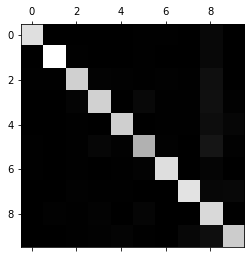

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

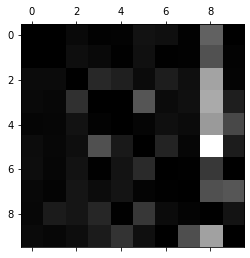

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

'8'의 오답발생 빈도가 높고, '5'와 혼동되는 경우가 많음을 알 수 있습니다.

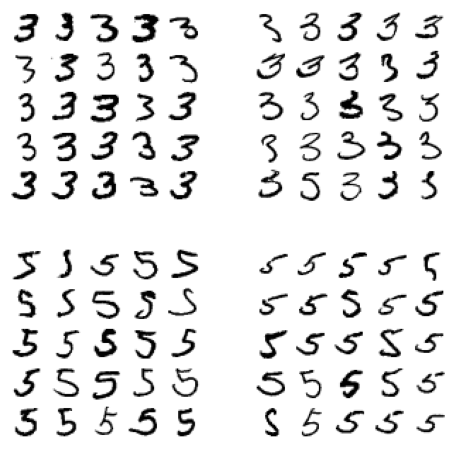

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8, 8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

## 다중 레이블 분류
여러 클래스가 있고 각 샘플이 그 중 하나에 해당하는 경우가 다중 클래스 분류라면,\
하나의 샘플이 여러 클래스에 속하는 경우는 다중 레이블 분류라고 합니다.\
여기서는 (1) 7 이상인지(7, 8, 9), (2) 홀수인지(1, 3, 5, 7, 9) 여부로 2개 클래스를 생성하고 다중 레이블 분류를 수행합니다.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [ ]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

## 7. 다중 출력 분류
다중 출력 분류는 한 레이블에 값을 여러 개 가질 수 있는 경우입니다. (many-to-many)

In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

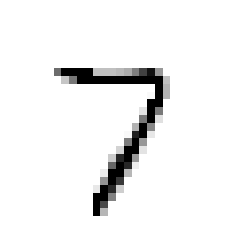

In [ ]:
some_index = 0
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)